# Setup

In [1]:
# Data-handling imports
import pandas as pd

# Text-handling imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Graphing libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Random seed
seed = 5993

In [2]:
# Run this once to download VADER lexicon (Hutto & Gilbert 2014)
# import nltk
# nltk.download('vader_lexicon')

# Data import & cleaning

In [3]:
# Read in data
df = pd.read_csv("../data/COVID.csv")

In [4]:
cities = ["Houston", "New York"]
regexes = ["^(?:Houston)", "^(?:NYC|New York|Bronx|Manhattan|Brookyn|Queens|Staten Island)"]

dfs = {}
for city, regex in zip(cities, regexes):
    # Create data frame
    dfs[city] = pd.DataFrame()
    
    # Subset original data
    mask = df["Tweet Location"].str.contains(regex, na=False)
    
    # Add columns
    dfs[city]["id"] = df[mask]["Tweet Id"]
    dfs[city]["text"] = df[mask]["Tweet Content"]
    dfs[city]["city"] = city
    dfs[city]["time"] = pd.to_datetime(df[mask]["Tweet Posted Time (UTC)"])
    
    #dfs[city].set_index("id", inplace=True)

# Compile dataframe with text
covid = pd.concat(dfs).reset_index(drop=True)
covid.set_index("id", inplace=True)

In [5]:
# Check if we're balanced across cities
covid["city"].value_counts(normalize=True) * 100

New York    92.025316
Houston      7.974684
Name: city, dtype: float64

# Sentiment analysis

In [6]:
# Instantiate sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiments
sentiments = pd.DataFrame([analyzer.polarity_scores(text) for text in covid["text"]])

# Append to original data frame
covid = pd.concat([covid, sentiments.set_index(covid.index)], axis=1)

# Graphs

In [7]:
def plt_setup(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=28)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(labelsize=16)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

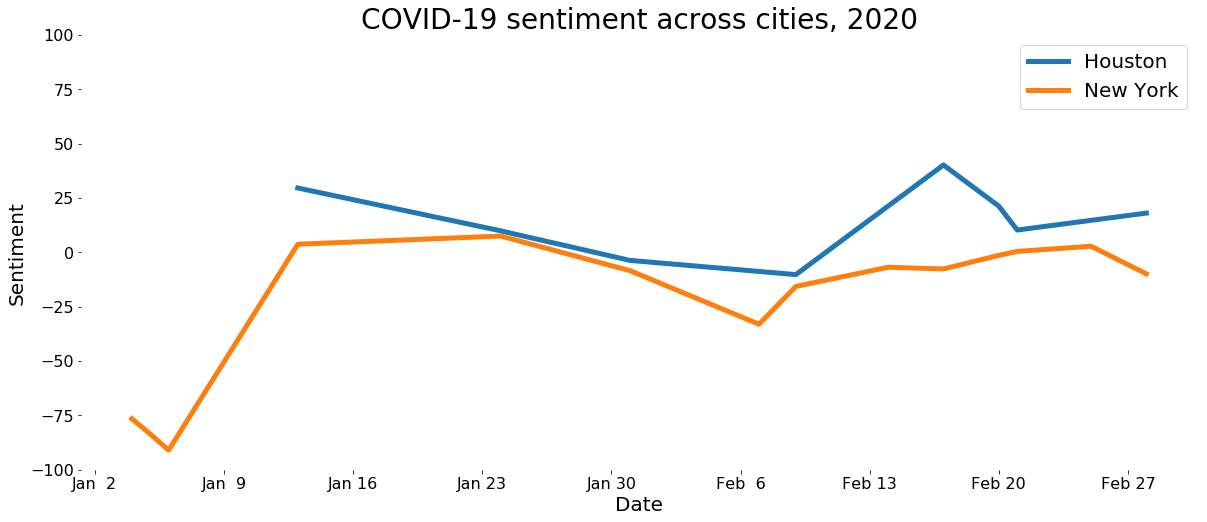

In [8]:
# Configure plots
fig, ax = plt.subplots(figsize=(20, 8))
plt_setup(ax,
         "COVID-19 sentiment across cities, 2020",
         "Date",
         "Sentiment"
         )
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %e"))
ax.set_ylim((-100, 100))

# Draw line plot
for city in cities:
    subset = covid[covid["city"] == city]
    subset_mean = subset.groupby(subset["time"].dt.date).mean()
    ax.plot(subset_mean.index, subset_mean["compound"] * 100, linewidth=5, label=city);

ax.legend(fontsize=20);

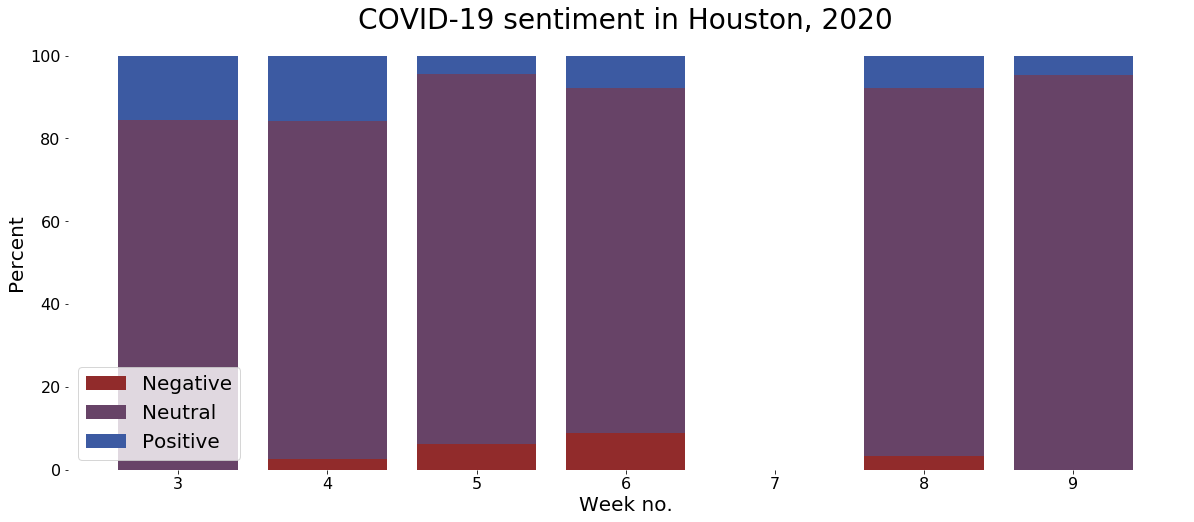

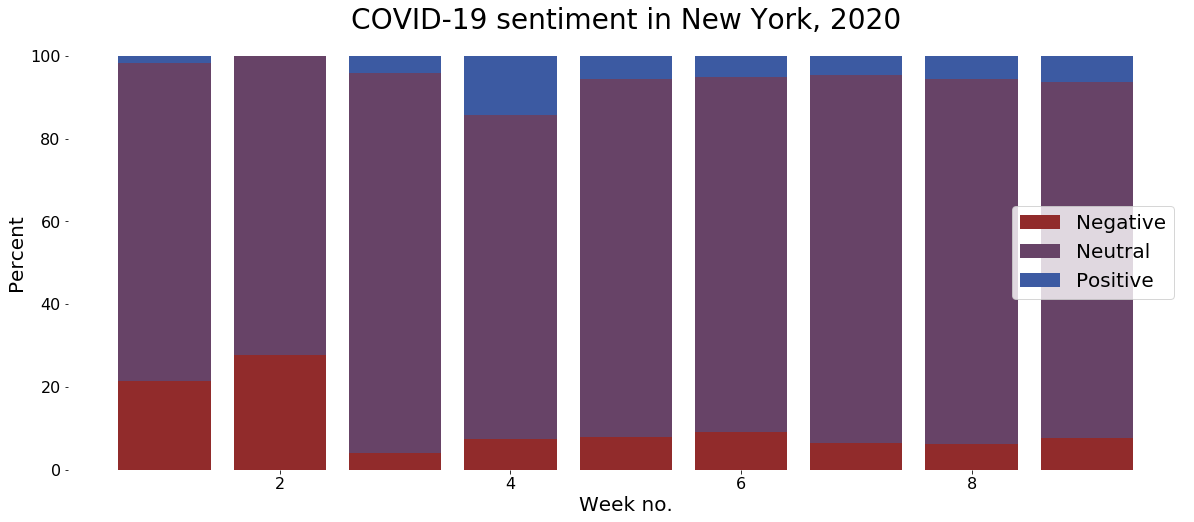

In [9]:
for city in cities:
    subset = covid[covid["city"] == city]
    subset_mean = subset.groupby(subset["time"].dt.week).mean()

    # Configure plots
    fig, ax = plt.subplots(figsize=(20, 8))
    plt_setup(ax,
              f"COVID-19 sentiment in {city}, 2020",
              "Week no.",
              "Percent"
             )

    # Draw stacked bar plots
    ax.bar(subset_mean.index, subset_mean["neg"] * 100, color="#912B2B", linewidth=5, label="Negative");
    ax.bar(subset_mean.index, subset_mean["neu"] * 100, color="#674367", linewidth=5, label="Neutral",  bottom=subset_mean["neg"] * 100);
    ax.bar(subset_mean.index, subset_mean["pos"] * 100, color="#3C5AA2", linewidth=5, label="Positive", bottom=(subset_mean["neg"] + subset_mean["neu"]) * 100);

    ax.legend(fontsize=20);

# Data export

# References

Hutto, C. J. and Gilbert, E. E. Aug. 2014. [VADER: A parsimonious rule-based model for sentiment analysis of social media text.](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/view/8109) In Adar, E., Resnick, P., Choudhury, M. D., Hogan, B., and Oh, A. H., eds., *Proceedings of the Eighth International Conference on Weblogs and Social Media*, pp. 216–225. Palo Alto, CA: AAAI Press